In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler

In [2]:
# Global vars;
# According to <Assignment Questions> section;

nsrcs = 6
N = 240
V = 441
SM_SIZE = 21

x1 = 21
x2 = 21

# Q1

### Functions

In [3]:
# Generate a TC source;

# AV:       arrival vector;
# IV:       interval vector;
# duration: duration vector;
# idx:      position of input parameters to use;
# n:        number of samples in TC;

def generate_tc(av, iv, dur, idx, n):
    _N = n
    _arrival = av[idx]  # Arrival of first batch;
    _increment = iv[idx]  # Interval to future batch;
    _duration = dur[idx]  # Duration of ones;
    
    values = []  # Array of values to return;
    
    # ====================
    # Pre-calculate all the index positions so we can fill in 1s and 0s accordingly;
    
    # Get position of each batch;
    _batches = [_arrival + (_increment * x) 
                for x in range(1, int((_N-_arrival)/_increment)+1)]
    
    # Get position of each end of ones;
    _ones_ends = [n + _duration for n in _batches]                                                                                                   
    
    
    # ====================
    # First, fill any pre-arrival zeros;
    for i in range(0, _arrival):
        values.append(0)
        
    # Then, fill the batches;
    _val = 1
    for i in range(_arrival, _N):
        
        # If this value is at the start of a batch, make it 1;
        if (i in _batches):
            _val = 1
            #print("batch start: " + str(i))
            
        # If this value is after the end of ones, make it 0;
        if (i == _arrival + _duration or i in _ones_ends):
            _val = 0
            #print("ones end: " + str(i))
            
        # Append this value to output;
        values.append(_val)
        
    return values

In [4]:
# Generate and get an array of TC sources;

# AV:       arrival vector;
# IV:       interval vector;
# duration: duration vector;
# total:    number of TCs to make (i.e. length of vectors);
# n:        number of samples in each TC;

def get_tcs(AV, IV, duration, total, n):  
    tc_list = []  
    for i in range(0, total):
        _tc = generate_tc(AV, IV, duration, i, n)
        tc_list.append(_tc)     
    return tc_list

In [5]:
# Standardize values;

# values: array of input values;

def standardize_values(values):
    z = (values - np.mean(values)) / np.std(values)
    return z

# Q1-1 Construct TC

In [6]:
AV = [0,20,0,0,0,0]
IV = [30,45,60,40,40,40]
duration = [15,20,25,15,20,25]

In [7]:
tcs = get_tcs(AV, IV, duration, 6, 240)

In [8]:
# Standardize all TCs

tcs_standardized = [standardize_values(tc) for tc in tcs]

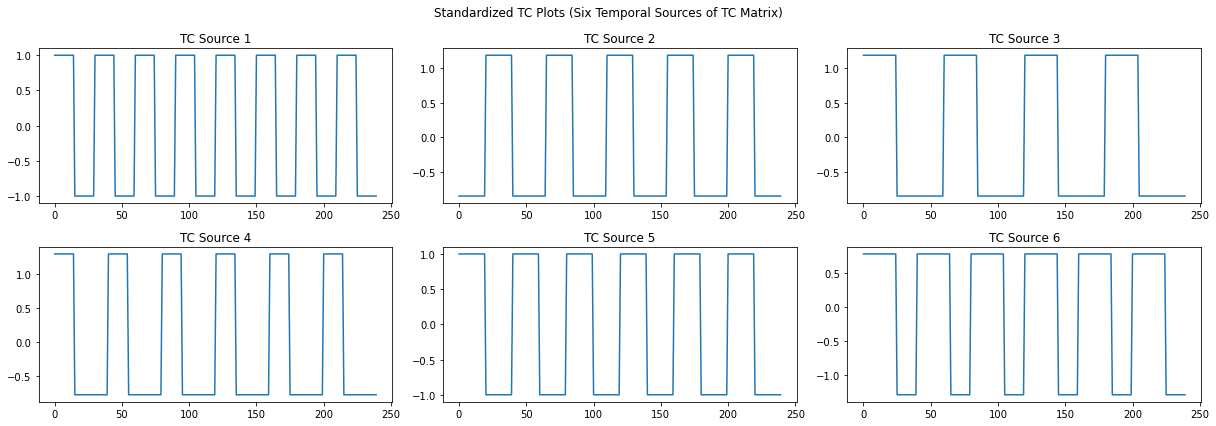

In [9]:
# Plot all 6 standardized TCs;

fig, axes = plt.subplots(2, 3, figsize=(17,6))

fig.suptitle('Standardized TC Plots (Six Temporal Sources of TC Matrix)')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
            
        tc = tcs_standardized[idx]
        sns.lineplot(data=tc, ax=axes[i,j])
        axes[i, j].set_title("TC Source " + str(idx+1))
        
fig.tight_layout()
plt.show()

In [10]:
# Construct matrix TC;

TC_df = pd.DataFrame(tcs_standardized).T

# Q1-2 Correlation Matrix

In [11]:
TC_corr = TC_df.corr()

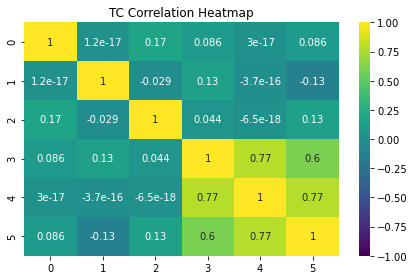

In [12]:
# Correlation heatmap;
fig = sns.heatmap(TC_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis")
fig.set_title("TC Correlation Heatmap")
plt.tight_layout()
plt.show()

In [13]:
# TC sources 3, 4, 5 are highly correlated;

# Q1-3 Construct tmpSM Array

In [14]:
# Create tmpSM array of six 21x21 SMs;
# For each SM, put ones at specified (vertical, horizontal) positions;

# Define ranges;
ones_ranges = [
    ((2,6),(2,6)),
    ((2,6),(15,19)),
    ((8,13),(2,6)),
    ((8,13),(15,19)),
    ((15,19),(2,6)),
    ((15,19),(15,19))]

# Initialize tmpSM;
initSM = []
for n in range(0,6):
    sm = np.zeros((21, 21))
    ranges = ones_ranges[n]
    vertical_range = range(ranges[0][0]-1, ranges[0][1])
    horizontal_range = range(ranges[1][0]-1, ranges[1][1])
    
    for i in vertical_range:
        for j in horizontal_range:
            sm[i][j] = 1
    
    initSM.append(sm)

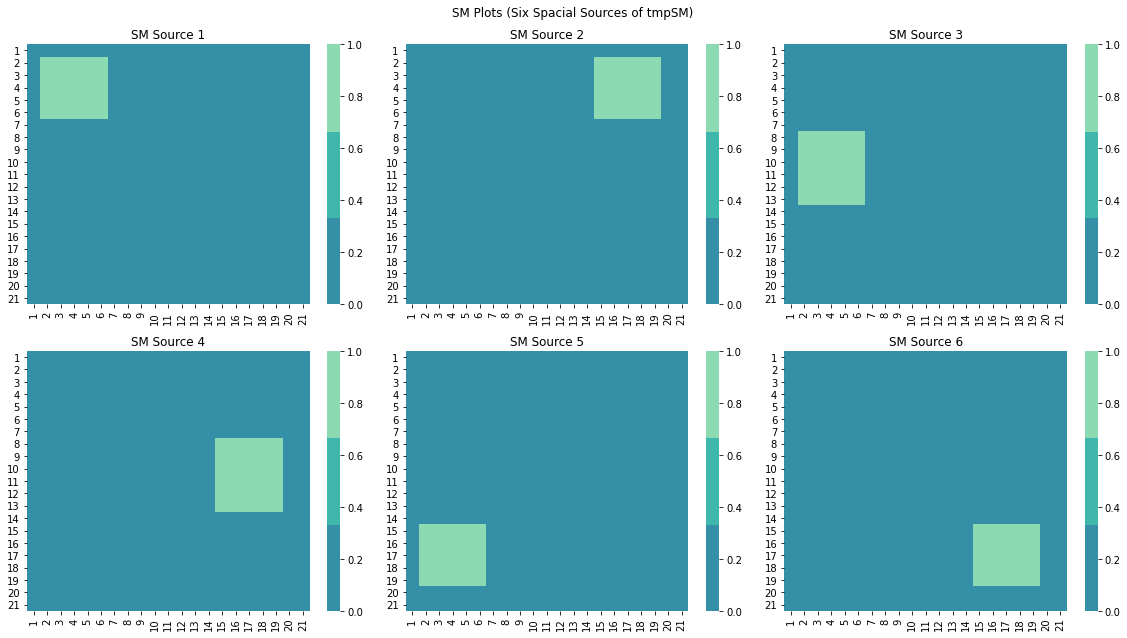

In [15]:
# Plot each SM;

tmpSM = initSM

fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('SM Plots (Six Spacial Sources of tmpSM)')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.heatmap(data=sm, cmap=sns.color_palette("mako"),
                    xticklabels=list(range(1,22)),
                    yticklabels=list(range(1,22)),
                    vmin=0, vmax=1, center=0, ax=axes[i,j])
        axes[i, j].set_title("SM Source " + str(idx+1))
            
fig.tight_layout()
plt.show()

In [16]:
# Reshape each SM source into 1 * 441 matrix;
# Then combine into 6 * 441 matrix;


# Reshape each SM source, transpose first to keep columns;
SM = [sm.transpose().reshape(1,441) for sm in tmpSM] 

# Combine SM sources;
SM = np.stack(SM)

# Remove nesting;
SM = [list(itertools.chain(*nested)) for nested in SM]

In [17]:
SM_df = pd.DataFrame(SM)

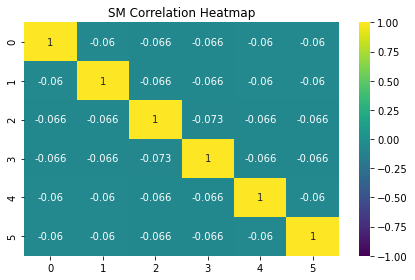

In [18]:
# Correlation heatmap;

SM_corr = SM_df.T.corr()

fig = sns.heatmap(SM_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis")
fig.set_title("SM Correlation Heatmap")
plt.tight_layout()
plt.show()

# Q1-4 Generate Zero Mean White Gaussian Noise

In [19]:
def generate_noise(mean, sd, dimensions):
    noise = np.random.normal(mean, sd, dimensions)
    return pd.DataFrame(noise) 

In [20]:
# Noise for TC: 240 rows * 6 columns, variance: 0.25;;
# Noise for SM: 6 rows * 441 columnsm, variance: 0.015

noise_t = generate_noise(0, np.sqrt(0.25), (240,6))
noise_s = generate_noise(0, np.sqrt(0.015), (6, 441))

### Plots for noise

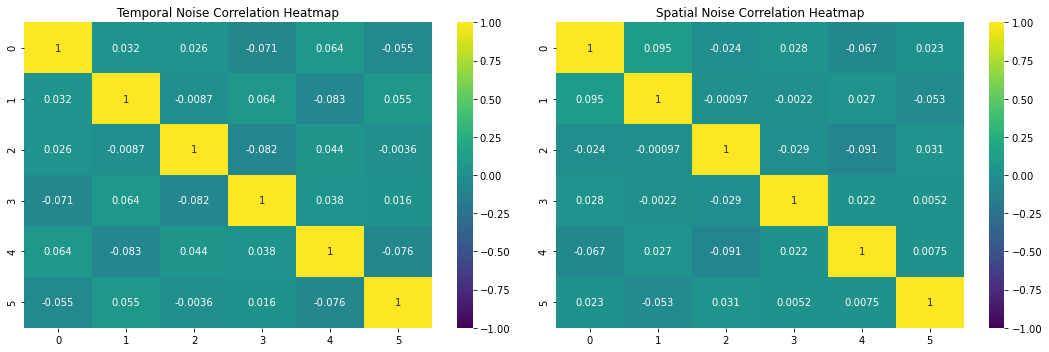

In [21]:
# Correlation heatmaps for temporal and spatial noise sources;

noise_t_corr = noise_t.corr()
noise_s_corr = noise_s.T.corr()

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.heatmap(noise_t_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis", ax=axes[0])
axes[0].set_title("Temporal Noise Correlation Heatmap")

sns.heatmap(noise_s_corr, annot=True, 
                  vmin=-1, vmax=1, center=0, cmap="viridis", ax=axes[1])
axes[1].set_title("Spatial Noise Correlation Heatmap")

fig.tight_layout()
plt.show()

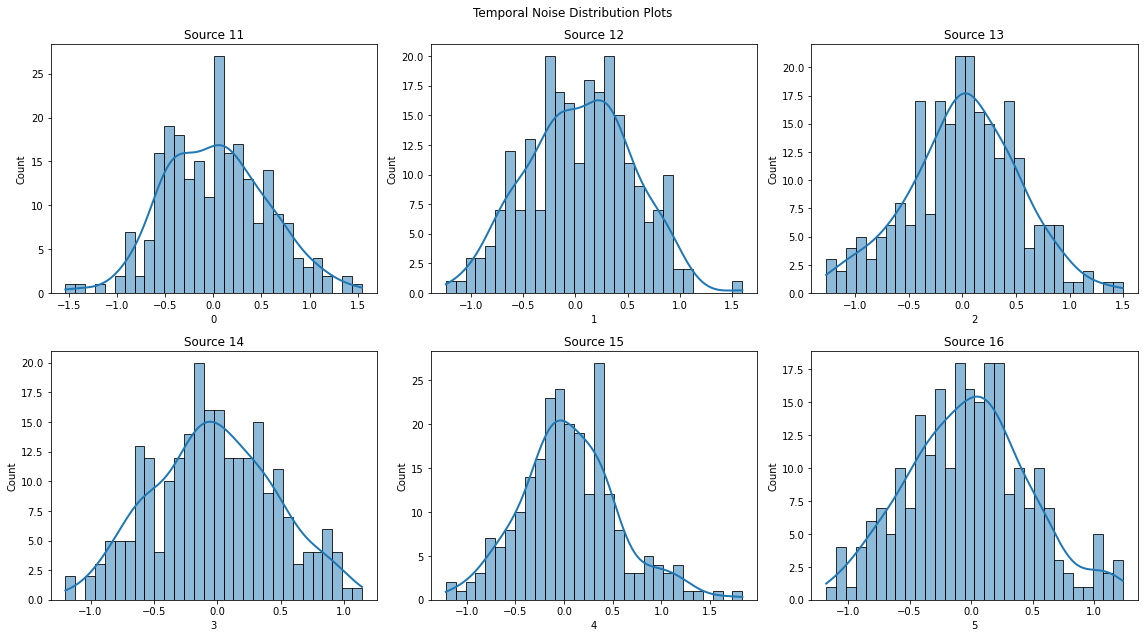

In [22]:
# Distribution histograms of temporal and spatial noise sources;
fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('Temporal Noise Distribution Plots')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.histplot(ax=axes[i,j], data=noise_t[idx], bins=30,
             kde=True,
             line_kws={"linewidth":2})
        axes[i, j].set_title("Source 1" + str(idx+1))
    
fig.tight_layout()
plt.show()

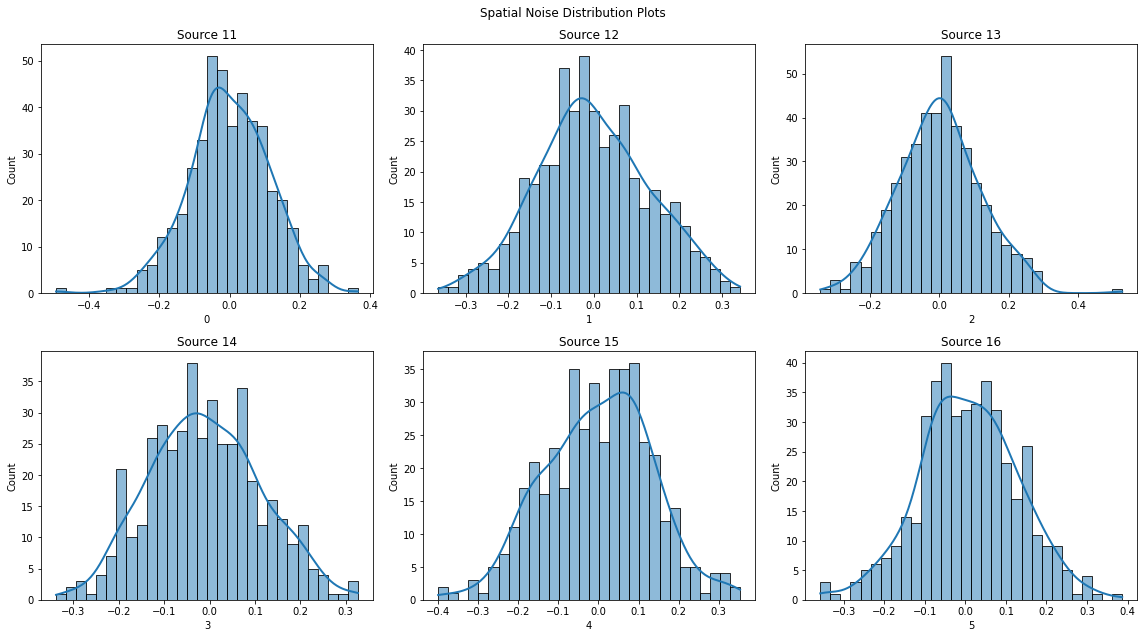

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(16,9))

fig.suptitle('Spatial Noise Distribution Plots')

for i in range(0, 2):
    for j in range(0, 3):
        idx = i+j
        if(i!=0):
            idx += i+1
        sm = tmpSM[idx]
        sns.histplot(ax=axes[i,j], data=noise_s.T[idx], bins=30,
             kde=True,
             line_kws={"linewidth":2})
        axes[i, j].set_title("Source 1" + str(idx+1))
        
fig.tight_layout()
plt.show()

# Q1-5 Generate Synthetic Dataset

In [24]:
# Use numpy 2D-arrays for matrix operations.

TC = TC_df.values
Gt = noise_t.values
SM = SM_df.values
Gs = noise_s.values

X_init = np.dot((TC+Gt), (SM+Gs))

# Use df for visualizing;
X_init_df = pd.DataFrame(X_init)

In [25]:
X_subset_df = X_init_df.sample(n=5,axis='columns', random_state = 353)

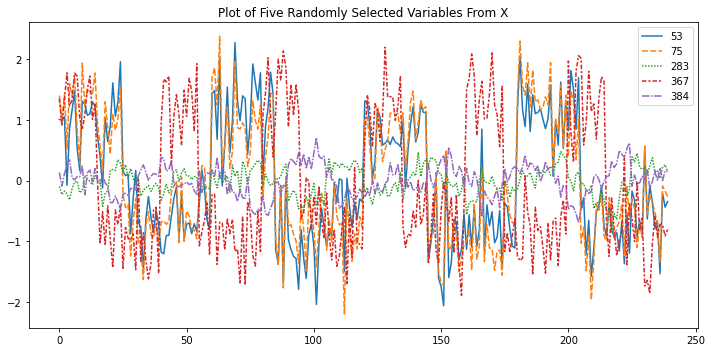

In [26]:
# Plot randomly selected variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.lineplot(data=X_subset_df, )
axes.set_title("Plot of Five Randomly Selected Variables From X")


plt.tight_layout()
plt.show()

In [27]:
X_stats_df = pd.DataFrame()
X_stats_df["variance"] = X_init_df.var()

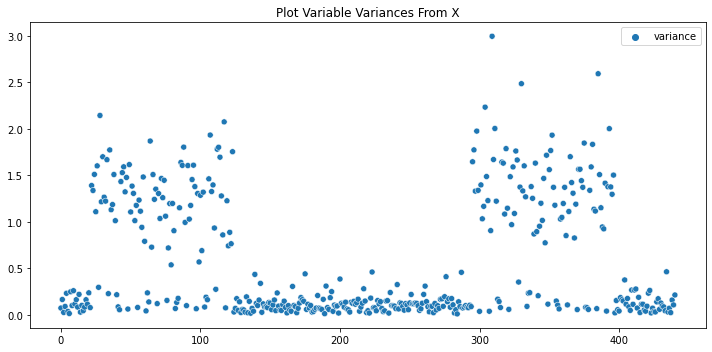

In [28]:
# Plot variance of each of the 441 variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.scatterplot(data=X_stats_df)
axes.set_title("Plot Variable Variances From X")


plt.tight_layout()
plt.show()

In [29]:
X_standardized_df = pd.DataFrame(standardize_values(X_init_df[col]) for col in X_init_df).T

# Q2

# Q2-1 LSR Estimations

In [30]:
# Using generated X_standardized;
# This dataset follows X = DA + E;

X = X_standardized_df.values
D = TC

In [31]:
# Estimate A_lsr;
# A_lsr = inv(DtD) %*% DtX;

DtD = np.dot(D.transpose(), D)

DtX = np.dot(D.transpose(), X)

A_lsr = np.dot(np.linalg.pinv(DtD), DtX)

# Retrieve D_lsr using A_lsr;
# D_lsr = X %*% t(A_lsr)

D_lsr = np.dot(X, A_lsr.transpose())

### Plots for LSR estimations

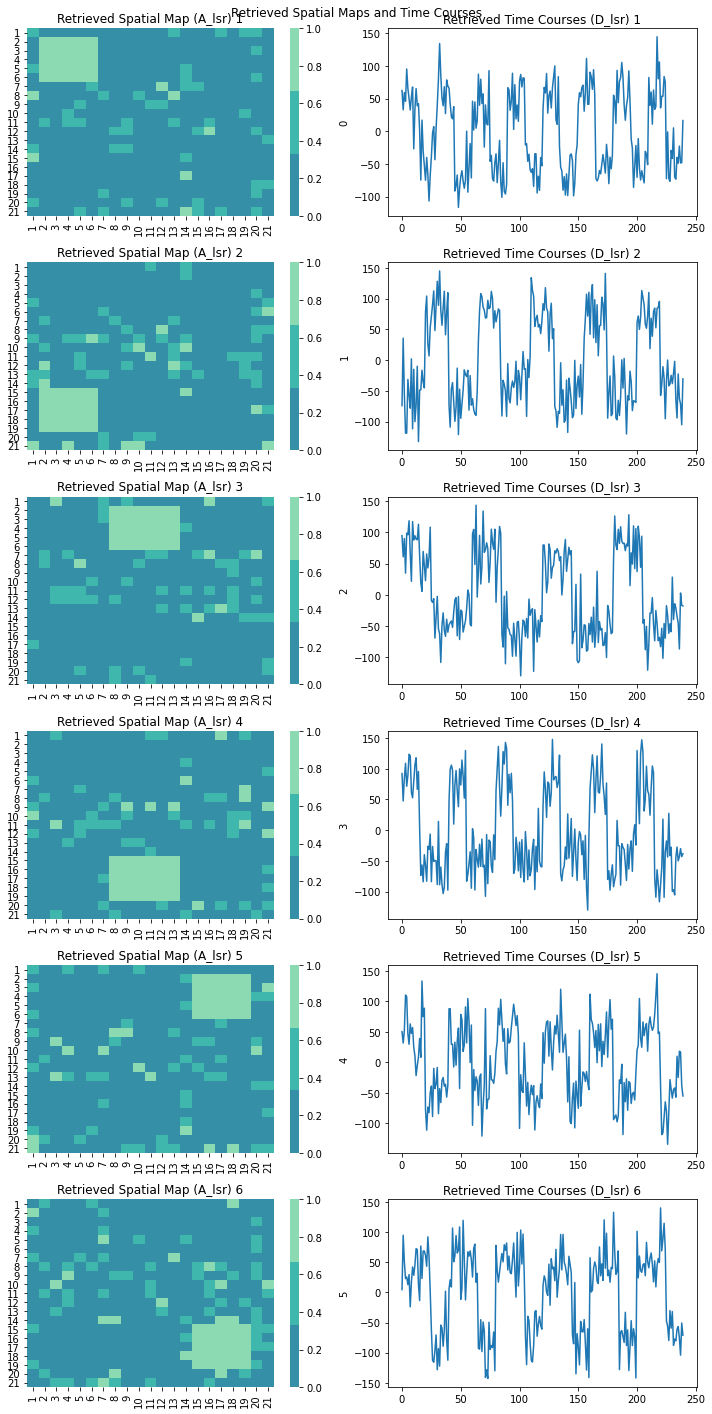

In [32]:
D_lsr_df = pd.DataFrame(D_lsr)

# Plot retrieced A_lsr and D_lsr for six sources;

fig, axes = plt.subplots(6, 2, figsize=(10,20))

fig.suptitle('Retrieved Spatial Maps and Time Courses')

# For each source;
for i in range(0, 6):
    idx = i
    
    # Get corresponding 21 * 21 sm source from A_lsr;
    sm_idx = int(21*(idx+1))
    A_lsr_sm = A_lsr.reshape(126,21)[sm_idx-21:sm_idx,:]

    # Plot A_lsr;
    sns.heatmap(data=A_lsr_sm, cmap=sns.color_palette("mako"),
                xticklabels=list(range(1,22)),
                yticklabels=list(range(1,22)),
                vmin=0, vmax=1, center=0, ax=axes[i, 0])
    axes[i, 0].set_title("Retrieved Spatial Map (A_lsr) " + str(idx+1))
    
    # Plot D_lsr;
    sns.lineplot(data=D_lsr_df[idx], ax=axes[i, 1])
    axes[i, 1].set_title("Retrieved Time Courses (D_lsr) " + str(idx+1))
    
        
fig.tight_layout()
plt.show()

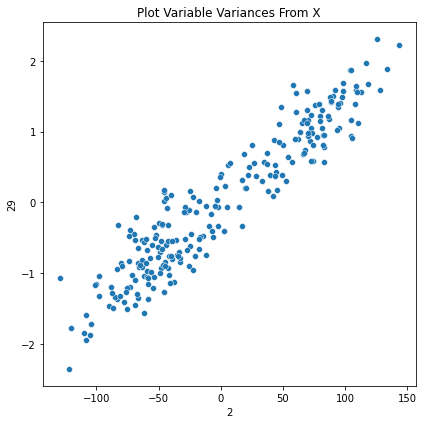

In [33]:
# Plot variance of each of the 441 variables (columns) from X;

fig, axes = plt.subplots(figsize=(6,6))

sns.scatterplot(x=D_lsr_df[2], y=X_standardized_df[29])
axes.set_title("Plot Variable Variances From X")
# plt.ylim(-5,5)

plt.tight_layout()
plt.show()

# Q2-2 RR Estimations

In [34]:
# Penalty parameter;
lambda_hat = 1 * V

# A_rr = inv(DtD + lambda_hat*I) %*% DtX;
A_rr = np.dot(np.linalg.pinv(DtD + lambda_hat * np.identity(6)), DtX)

# D_rr = X %*% t(A_rr);
D_rr = np.dot(X, A_rr.transpose())

In [35]:
D_lsr_df = pd.DataFrame(D_lsr)
D_rr_df = pd.DataFrame(D_rr)

In [36]:
# For each TC column, get its correlation with each D_lsr column;
for col in TC_df:
    for i in D_lsr_df:
        corr = D_lsr_df[i].corr(TC_df[col])
        #print(corr)

In [37]:
# columns: D_lsr;
# rows: TC;

c_tlsr_df = pd.concat([TC_df, D_lsr_df], axis=1).corr()\
                    .iloc[0:6,6:12].reset_index(drop=True)
c_tlsr = np.diag(c_tlsr_df)


In [38]:
c_trr_df = pd.concat([TC_df, D_rr_df], axis=1).corr()\
                    .iloc[0:6,6:12].reset_index(drop=True)
c_trr = np.diag(c_trr_df)

In [39]:
sum_c_tlsr = sum(c_tlsr)
sum_c_trr = sum(c_trr)
print("Sum of c_tlsr: " + str(sum_c_tlsr))
print("Sum of c_trr: " + str(sum_c_trr))

print("Sum of c_trr > Sum of c_tlsr: ")
print(sum_c_trr > sum_c_tlsr)

Sum of c_tlsr: 5.225799259341232
Sum of c_trr: 5.40360400422367
Sum of c_trr > Sum of c_tlsr: 
True


### Plots for RR estimations

In [40]:
A_lsr_df = pd.DataFrame(A_lsr)
A_rr_df = pd.DataFrame(A_rr)

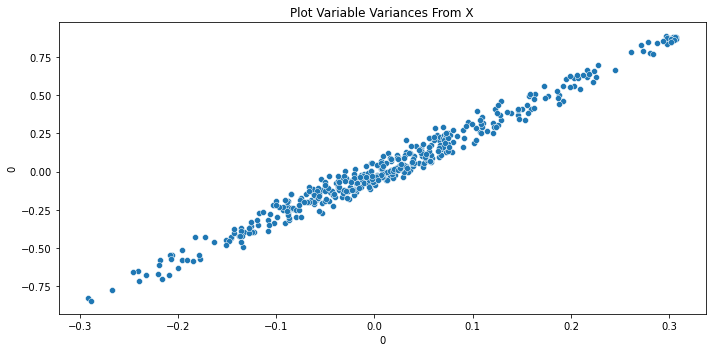

In [41]:
# Plot variance of each of the 441 variables (columns) from X;

fig, axes = plt.subplots(figsize=(10,5))

sns.scatterplot(x=A_rr_df.T[0], y=A_lsr_df.T[0])
axes.set_title("Plot Variable Variances From X")
# plt.ylim(-5,5)

plt.tight_layout()
plt.show()

# Q2-3 LR rho Selection

### Function to generate X_standardized on-demand

In [42]:
# Get a df of standardized X dataset;

# tc:       TC dataframe;
# sm:       SM dataframe;
# noise_tc: temporal noise dataframe;
# noise_sm: spatial noise dataframe;

def generate_X(tc, sm, noise_tc, noise_sm):
    
    _TC = tc.values
    _Gt = noise_tc.values
    _SM = sm.values
    _Gs = noise_sm.values
    
    # Calculate X;
    _X = np.dot((_TC+_Gt), (_SM+_Gs))
    
    # Standardize X via df;
    _X_df = pd.DataFrame(_X)
    X_output_df = pd.DataFrame(standardize_values(_X_df[col]) for col in _X_df).T
    
    return X_output_df

### Function for LR

In [80]:
# Function for estimating LR parameters A_lr and D_lr;

# X:   standardized X dataset;
# D:   TC dataset;
# rho: rho parameter;

def estimate_lr(X, D, rho):
    step = 1/np.linalg.norm(np.dot(D, D.transpose()) * 1.1)
    thr = rho * N * step
    Ao = np.repeat(0, nsrcs)
    A = np.repeat(0, nsrcs)
    A_lr = np.zeros((nsrcs, x1*x2))
    
    for k in range(1, (x1*x2)+1):
        A = Ao + step * ( np.dot( D.transpose(), (X[:,k-1] - np.dot(D, Ao)) ) )
        A = (1/(1+thr)) * (np.sign(A) * np.maximum(np.repeat(0, nsrcs), np.abs(A)-thr))
        for i in range(1,11):
            Ao = A
            A = Ao + step * ( np.dot(D.transpose(), (X[:,k-1] - np.dot(D, Ao))) )
            A = (1/(1+thr)) * (np.sign(A) * np.maximum(np.repeat(0, nsrcs), np.abs(A)-thr))
                
        # Get A_lr and D_lr;
        A_lr[:,k-1] = A
        
    D_lr = np.dot(X, A_lr.transpose())
    MSE = np.square(np.linalg.norm(X - np.dot(D_lr, A_lr))) / (N*V)
        
    return (A_lr, D_lr, MSE)

In [44]:
# Generate rhos;
rhos = [i/100 for i in np.arange(0,101,5)]

In [85]:
# Get MSEs for 10 realizations
MSE_matrix = []

for i in range(0,10):
    
    # Generate X_standardized;
    noise_t = generate_noise(0, np.sqrt(0.25), (240,6))
    noise_s = generate_noise(0, np.sqrt(0.015), (6, 441))

    X_standardized_df_instance = generate_X(TC_df, SM_df, noise_t, noise_s)
    X = X_standardized_df_instance.values
    D = TC_df.values

    # Collect MSE for each of 21 rhos in this realization;
    MSE_values = []
    
    # For each of 21 rhos, estimate A_lr and D_lr and get the MSE sum;
    print("--------------------")
    for rho in rhos:   
        
        # Estimate using this rho;
        lr = estimate_lr(X, D, rho)
      
        # Get MSE for this rho;
        MSE_values.append(lr[-1])
        print("rho: " + str(rho) + ", MSE: " + str(lr[-1]))
    
    # After going through 21 rhos, append the MSEs for this realization;
    MSE_matrix.append(MSE_values)

# --> Get 21 * 10 matrix of MSEs;

--------------------
rho: 0.0, MSE: 3019.3312596127753
rho: 0.05, MSE: 1734.0169675411003
rho: 0.1, MSE: 992.3585583325123
rho: 0.15, MSE: 560.2432163670865
rho: 0.2, MSE: 308.38965713115465
rho: 0.25, MSE: 164.4133686792272
rho: 0.3, MSE: 84.05577823513211
rho: 0.35, MSE: 40.63356973924206
rho: 0.4, MSE: 18.263328383691235
rho: 0.45, MSE: 7.428776472392015
rho: 0.5, MSE: 2.682381495500103
rho: 0.55, MSE: 0.9258110693472301
rho: 0.6, MSE: 0.5039199730762408
rho: 0.65, MSE: 0.5682122322953668
rho: 0.7, MSE: 0.7426679347310392
rho: 0.75, MSE: 0.8856268868527691
rho: 0.8, MSE: 0.9662271466461119
rho: 0.85, MSE: 0.9964688040900083
rho: 0.9, MSE: 0.9999869106639723
rho: 0.95, MSE: 0.9999999999999998
rho: 1.0, MSE: 0.9999999999999998
--------------------
rho: 0.0, MSE: 2780.927059091
rho: 0.05, MSE: 1575.6774903271596
rho: 0.1, MSE: 888.4051799916089
rho: 0.15, MSE: 494.10898645679316
rho: 0.2, MSE: 268.4077310276563
rho: 0.25, MSE: 141.39044785315713
rho: 0.3, MSE: 71.28806796707688
rho: 0.

### Visualize

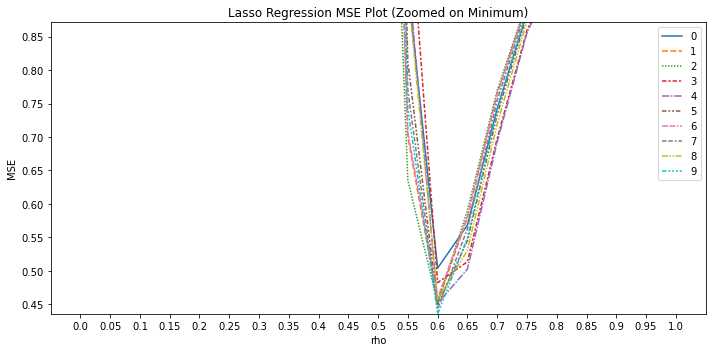

In [86]:
MSE_matrix_df = pd.DataFrame(MSE_matrix).T

fig, axes = plt.subplots(1, figsize=(10,5))

sns.lineplot(data=MSE_matrix_df)

axes.set_title("Lasso Regression MSE Plot (Zoomed on Minimum)")

axes.set_xticks(range(0,21))
axes.set_xticklabels(rhos)

axes.set_ylim([MSE_matrix_df.min().min(),MSE_matrix_df.min().min()*2])

axes.set_xlabel("rho")
axes.set_ylabel("MSE")
            

plt.tight_layout()
plt.show()


In [72]:
# MSE is minimized for rho = 0.6;

# Q2-4

In [88]:
rho = 0.6
lr_estimate = estimate_lr(X, D, rho)
A_lr = lr_estimate[0]
D_lr = lr_estimate[1]

In [89]:
D_lr_df = pd.DataFrame(D_lr)

In [90]:
c_tlr_df = pd.concat([TC_df, D_lr_df], axis=1).corr()\
                    .iloc[0:6,6:12].reset_index(drop=True)
c_tlr = np.diag(c_tlr_df)

In [93]:
c_tlsr

array([0.88088198, 0.88740758, 0.87785333, 0.88321646, 0.81375037,
       0.88268954])

In [92]:
c_trr

array([0.88900623, 0.88872397, 0.88214078, 0.91388627, 0.91622476,
       0.91362198])

In [91]:
c_tlr

array([0.89373623, 0.89699111, 0.89579145, 0.91872314, 0.91305687,
       0.8994263 ])